In [96]:
import requests
import openai
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import logging
import time
from functools import wraps

import os
from dotenv import load_dotenv

In [97]:
# Load environment variables
load_dotenv()

# Check if the API keys are loaded
alphavantage_key = os.getenv("ALPHAVANTAGE_API_KEY")  # Corrected variable name
openai_key = os.getenv("OPENAI_API_KEY")

print(f"Alpha Vantage API key found: {'Yes' if alphavantage_key else 'No'}")
print(f"OpenAI API key found: {'Yes' if openai_key else 'No'}")

if not alphavantage_key or not openai_key:
    raise ValueError("One or more required API keys are missing from the environment variables.")

Alpha Vantage API key found: Yes
OpenAI API key found: Yes


In [98]:
# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("investment_tool.log"),
        logging.StreamHandler()
    ]
)

def timeit(func):
    @wraps(func)
    def timed(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        logging.info(f"Function '{func.__name__}' executed in {elapsed_time:.4f} seconds")
        return result
    return timed

In [99]:
class StockAPIClient:
    def __init__(self):
        self.api_key = os.getenv("ALPHAVANTAGE_API_KEY")
        if not self.api_key:
            raise ValueError(
                "Alpha Vantage API key not found in environment variables. "
                "Please check that your .env file contains the correct variable name 'ALPHAVANTAGE_API_KEY'."
            )
        self.base_url = "https://www.alphavantage.co/query"
        logging.info(f"API Key found: {'*' * (len(self.api_key) - 4)}{self.api_key[-4:]}")

    @timeit
    def get_stock_data(self, symbol: str, start_date: str, end_date: str) -> dict:
        """
        Obtiene datos históricos del mercado bursátil para un símbolo dado en un rango de fechas.
        """
        params = {
            'function': 'TIME_SERIES_DAILY',
            'symbol': symbol,
            'apikey': self.api_key,
            'outputsize': 'full',
            'datatype': 'json'
        }
        
        logging.info(f"Requesting data for {symbol} from {start_date} to {end_date}")
        logging.info(f"API URL: {self.base_url}")
        logging.info(f"Params (excluding API key): {params}")
        
        response = requests.get(self.base_url, params=params)
        
        logging.info(f"Response status code: {response.status_code}")
        
        data = response.json()

        if 'Time Series (Daily)' in data:
            filtered_data = self._filter_data_by_date(data, start_date, end_date)
            logging.info(f"Filtered data points: {len(filtered_data)}")
            return filtered_data
        else:
            error_message = data.get("Note", data.get("Error Message", "Unexpected error occurred"))
            logging.error(f"Error fetching data: {error_message}")
            logging.error(f"Full response: {data}")
            return {}

    def _filter_data_by_date(self, data: dict, start_date: str, end_date: str) -> dict:
        """
        Filtra los datos obtenidos de la API según las fechas proporcionadas.
        """
        filtered_data = {date: info for date, info in data['Time Series (Daily)'].items() if start_date <= date <= end_date}
        return filtered_data

In [100]:
class InvestmentStrategyGenerator:
    def __init__(self):
        self.api_key = os.getenv("OPENAI_API_KEY")
        self.client = openai.OpenAI(api_key=self.api_key)
        logging.info("InvestmentStrategyGenerator initialized")

    @timeit
    def generate_strategy(self, stock_data: dict) -> str:
        """
        Generates an investment strategy based on stock data using the GPT model.
        """
        prompt = self._create_prompt(stock_data)
        
        try:
            response = self.client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are a financial expert."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=200,
                temperature=0.7
            )
            
            strategy = response.choices[0].message.content.strip()
            logging.info("Strategy generated successfully")
            return strategy
        except Exception as e:
            logging.error(f"Error generating strategy: {str(e)}")
            return "Unable to generate strategy due to an error."

    def _create_prompt(self, stock_data: dict) -> str:
        """
        Creates the prompt to request an investment strategy based on the provided data.
        """
        prompt = "Based on the following stock market data, provide an investment strategy:\n"
        for date, info in stock_data.items():
            prompt += f"Date: {date}, Open: {info['1. open']}, Close: {info['4. close']}\n"
        prompt += "\nSuggest a profitable investment strategy based on the data."
        return prompt

In [101]:
class StockDataVisualizer:
    def __init__(self):
        self.fig, self.ax = plt.subplots(figsize=(12, 6))
        logging.info("StockDataVisualizer initialized")

    def prepare_data(self, stock_data: dict) -> pd.DataFrame:
        """
        Converts the stock data dictionary to a pandas DataFrame.
        """
        if not stock_data:
            raise ValueError("No stock data available to visualize")
        
        df = pd.DataFrame.from_dict(stock_data, orient='index')
        df.index = pd.to_datetime(df.index)
        return df.astype(float)

    def plot_stock_prices(self, df: pd.DataFrame, symbol: str):
        """
        Plots the opening and closing prices of the stock.
        """
        if '4. close' not in df.columns or '1. open' not in df.columns:
            raise ValueError("Required columns '4. close' or '1. open' not found in the data")
        
        self.ax.plot(df.index, df['4. close'], label='Close Price')
        self.ax.plot(df.index, df['1. open'], label='Open Price')
        
        self.ax.set_title(f'{symbol} Stock Price')
        self.ax.set_xlabel('Date')
        self.ax.set_ylabel('Price (USD)')
        self.ax.legend()
        
        self.ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)

    def add_volume_subplot(self, df: pd.DataFrame):
        """
        Adds a subplot to display trading volume.
        """
        if '5. volume' not in df.columns:
            logging.warning("Volume data not available")
            return
        
        ax2 = self.ax.twinx()
        ax2.bar(df.index, df['5. volume'].astype(int), alpha=0.3, color='gray')
        ax2.set_ylabel('Volume')

    @timeit
    def visualize(self, stock_data: dict, symbol: str):
        """
        Creates and displays a visualization of the stock data.
        """
        try:
            df = self.prepare_data(stock_data)
            self.plot_stock_prices(df, symbol)
            self.add_volume_subplot(df)
            
            plt.tight_layout()
            plt.show()
            logging.info("Stock data visualization completed")
        except Exception as e:
            logging.error(f"Error visualizing data: {str(e)}")

    def save_plot(self, filename: str):
        """
        Saves the current plot to a file.
        """
        try:
            plt.savefig(filename)
            logging.info(f"Plot saved as {filename}")
        except Exception as e:
            logging.error(f"Error saving plot: {str(e)}")

In [102]:
class InvestmentTool:
    def __init__(self):
        self.stock_client = StockAPIClient()
        self.strategy_generator = InvestmentStrategyGenerator()
        self.visualizer = StockDataVisualizer()
        logging.info("InvestmentTool initialized")

    @timeit
    def run(self, symbol: str, start_date: str, end_date: str):
        """
        Executes the complete flow of obtaining stock market data, generating the investment strategy,
        and visualizing the data.
        """
        try:
            stock_data = self.stock_client.get_stock_data(symbol=symbol, start_date=start_date, end_date=end_date)
            
            if not stock_data:
                logging.warning(f"No data available for {symbol} between {start_date} and {end_date}")
                return

            # Visualize the stock data
            self.visualizer.visualize(stock_data, symbol)
            
            # Generate and print the investment strategy
            strategy = self.strategy_generator.generate_strategy(stock_data)
            logging.info("Generated Investment Strategy:")
            logging.info(strategy)

            # Optionally, save the plot
            self.visualizer.save_plot(f"{symbol}_stock_chart.png")
        
        except Exception as e:
            logging.error(f"An error occurred: {str(e)}")

2024-10-11 18:53:58,915 - INFO - API Key found: ************4QSA
2024-10-11 18:53:58,928 - INFO - InvestmentStrategyGenerator initialized
2024-10-11 18:53:58,937 - INFO - StockDataVisualizer initialized
2024-10-11 18:53:58,938 - INFO - InvestmentTool initialized
2024-10-11 18:53:58,938 - INFO - Requesting data for AAPL from 2023-01-01 to 2023-12-31
2024-10-11 18:53:58,939 - INFO - API URL: https://www.alphavantage.co/query
2024-10-11 18:53:58,939 - INFO - Params (excluding API key): {'function': 'TIME_SERIES_DAILY', 'symbol': 'AAPL', 'apikey': 'RP5ZYUI51G8Z4QSA', 'outputsize': 'full', 'datatype': 'json'}
2024-10-11 18:53:59,846 - INFO - Response status code: 200
2024-10-11 18:53:59,859 - INFO - Filtered data points: 250
2024-10-11 18:53:59,861 - INFO - Function 'get_stock_data' executed in 0.9226 seconds


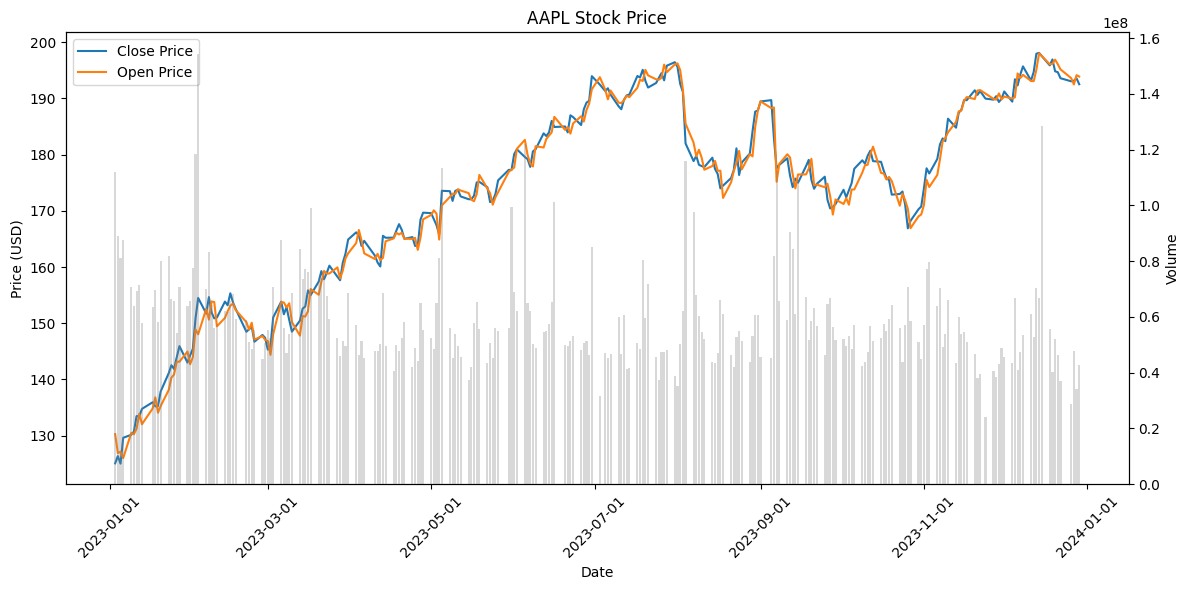

2024-10-11 18:54:00,096 - INFO - Stock data visualization completed
2024-10-11 18:54:00,096 - INFO - Function 'visualize' executed in 0.2346 seconds
2024-10-11 18:54:12,038 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-11 18:54:12,042 - INFO - Strategy generated successfully
2024-10-11 18:54:12,043 - INFO - Function 'generate_strategy' executed in 11.9462 seconds
2024-10-11 18:54:12,043 - INFO - Generated Investment Strategy:
2024-10-11 18:54:12,043 - INFO - Based on the provided data, we can see that there is a general upward trend in the stock's price over the time period. However, there are also noticeable fluctuations in the stock's price, which could present opportunities for both long-term investing and short-term trading.

For long-term investors:

Considering the overall upward trend, a viable strategy could be to invest in the stock and hold it for the long term. This approach would benefit from the general increase in the sto

<Figure size 640x480 with 0 Axes>

In [103]:
tool = InvestmentTool()
tool.run(symbol="AAPL", start_date="2023-01-01", end_date="2023-12-31")